In [1]:
from google.colab import drive
drive.mount('/content/drive')

CANDIDATE_NAME = "RohanJoshi"
BASE_DIR = f"/content/drive/MyDrive/ds_{CANDIDATE_NAME}"

CSV_FOLDER  = f"{BASE_DIR}/csv_files"
OUTPUT_FOLDER = f"{BASE_DIR}/outputs"
REPORT_FILE = f"{BASE_DIR}/ds_report.pdf"

import os
for folder in [BASE_DIR, CSV_FOLDER, OUTPUT_FOLDER]:
    os.makedirs(folder, exist_ok=True)

!apt-get install tree -qq > /dev/nul
!tree "{BASE_DIR}"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)
pd.set_option('display.max_columns', 50)

trades = pd.read_csv(f"{CSV_FOLDER}/trades_merged.csv", parse_dates=['time_utc','time_ist'])
agg_daily = pd.read_csv(f"{CSV_FOLDER}/daily_aggregates.csv", parse_dates=['trade_date'])

print("Trades shape:", trades.shape)
print("Daily aggregates shape:", agg_daily.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ds_RohanJoshi
├── csv_files
│   ├── daily_aggregates.csv
│   └── trades_merged.csv
├── DataIngestion&Validation.ipynb
├── ds_report.pdf
├── ExploratoryDataAnalysis&Analytics.ipynb
├── outputs
└── README.md

2 directories, 6 files
Trades shape: (211224, 24)
Daily aggregates shape: (480, 8)


In [2]:
print("Trades missing values:\n", trades.isna().sum()[trades.isna().sum()>0])
print("\nDaily aggregates missing values:\n", agg_daily.isna().sum()[agg_daily.isna().sum()>0])

print("\nSentiment distribution:")
print(trades['sentiment'].value_counts(dropna=False))

Trades missing values:
 sent_date    6
sentiment    6
dtype: int64

Daily aggregates missing values:
 sentiment    1
dtype: int64

Sentiment distribution:
sentiment
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
NaN                  6
Name: count, dtype: int64


## Performing EDA, for feature engineering and modelling.

/tmp/ipython-input-3499753690.py:14: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



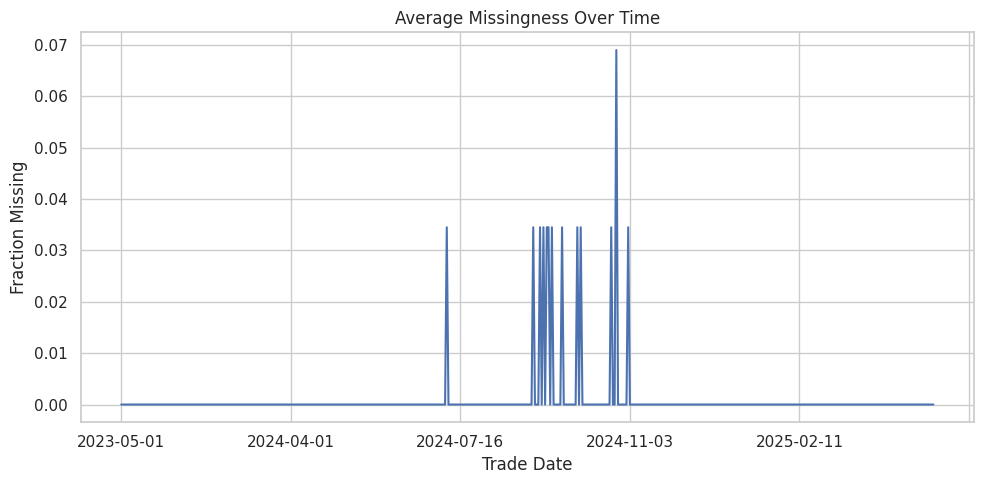

Duplicate rows: 0


In [44]:
# === DATA QUALITY & STABILITY ===
import matplotlib.dates as mdates

# Missingness by column
missing_summary = trades.isnull().mean().sort_values(ascending=False)
missing_summary.plot(kind='bar', color='crimson')
plt.title("Missing Value Ratio per Column")
plt.ylabel("Fraction Missing")
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/missing_by_column.png")
plt.close()

# Missingness over time
missing_time = trades.groupby('trade_date').apply(lambda x: x.isnull().mean().mean())
missing_time.plot()
plt.title("Average Missingness Over Time")
plt.ylabel("Fraction Missing")
plt.xlabel("Trade Date")
plt.tight_layout()
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/missing_over_time.png")
plt.close()

# Duplicate detection
dup_count = trades.duplicated().sum()
print(f"Duplicate rows: {dup_count:,}")

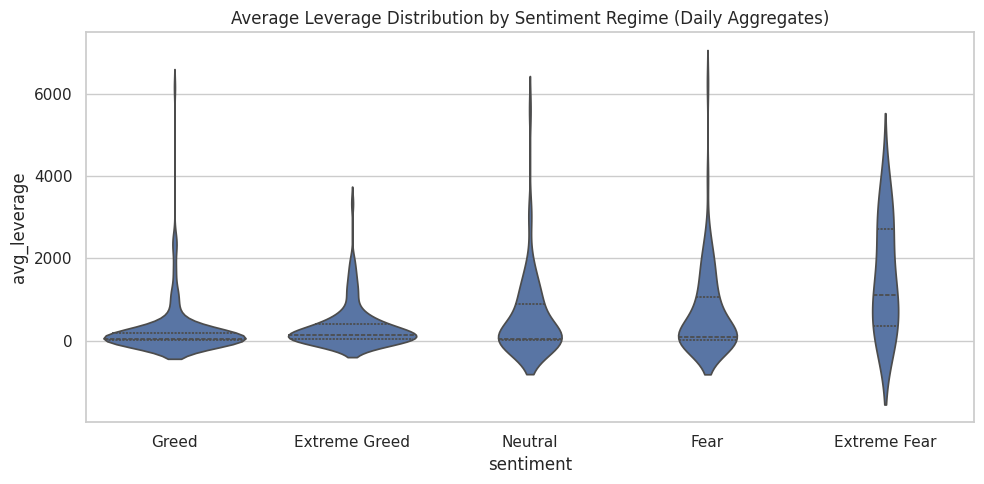

In [46]:
# Performance distribution by sentiment
sns.boxplot(data=trades, x='sentiment', y='pnl_pct')
plt.title("PNL % Distribution by Sentiment Regime")
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/pnl_by_sentiment.png")
plt.close()

# Leverage by sentiment
sns.violinplot(data=agg_daily, x='sentiment', y='avg_leverage', inner='quartile')
plt.title("Average Leverage Distribution by Sentiment Regime (Daily Aggregates)")
plt.tight_layout()
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/leverage_by_sentiment.png")
plt.close()

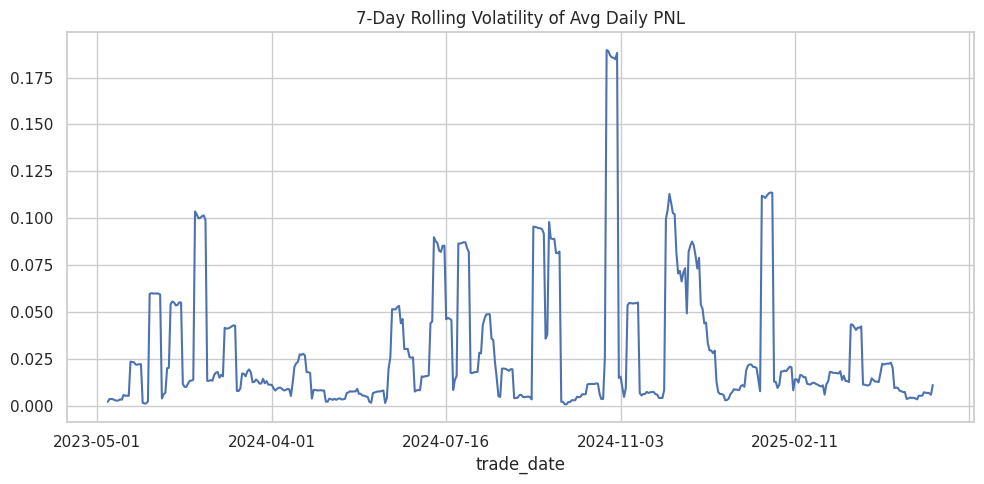

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF/PACF for daily average PNL
daily_pnl = trades.groupby('trade_date')['pnl_pct'].mean().dropna()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(daily_pnl, ax=ax[0], lags=30)
plot_pacf(daily_pnl, ax=ax[1], lags=30)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/acf_pacf_pnl.png")
plt.close()

# Rolling volatility
rolling_vol = daily_pnl.rolling(7).std()
rolling_vol.plot(title="7-Day Rolling Volatility of Avg Daily PNL")
plt.tight_layout()
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/rolling_volatility.png")
plt.close()

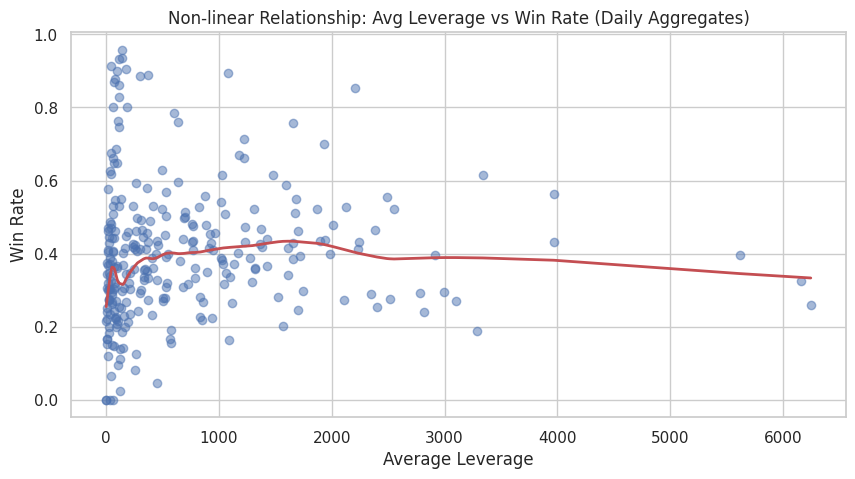

In [55]:
import statsmodels.api as sm

# LOWESS curve leverage vs win_rate
lowess = sm.nonparametric.lowess
xy = agg_daily.groupby('avg_leverage')['win_rate'].mean().reset_index()
z = lowess(xy['win_rate'], xy['avg_leverage'], frac=0.3)

plt.scatter(xy['avg_leverage'], xy['win_rate'], alpha=0.5)
plt.plot(z[:,0], z[:,1], 'r-', lw=2)
plt.title("Non-linear Relationship: Avg Leverage vs Win Rate (Daily Aggregates)")
plt.xlabel("Average Leverage") # Add x-axis label
plt.ylabel("Win Rate") # Add y-axis label
plt.show()
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/lowess_leverage_winrate.png")
plt.close()

Top 5 trades by PNL %:
         trade_date   pnl_pct     sentiment
144940  2025-04-09  3.403549  Extreme Fear
38937   2025-03-14  2.604130          Fear
47361   2025-02-03  1.822758          Fear
47362   2025-02-03  1.822758          Fear
47363   2025-02-03  1.822018          Fear

Bottom 5 trades by PNL %:
         trade_date     pnl_pct      sentiment
84039   2025-01-23 -384.505012  Extreme Greed
126726  2025-02-14  -23.358626        Neutral
126725  2025-02-14  -17.164820        Neutral
126724  2025-02-14  -13.777102        Neutral
138995  2025-02-02   -3.102057          Greed


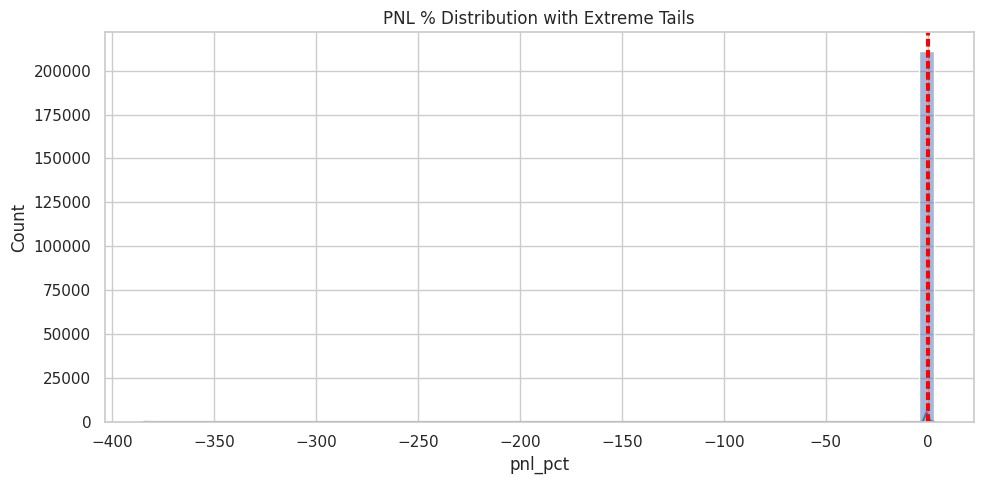

In [56]:
# Top/bottom trades by PNL
top_trades = trades.nlargest(5, 'pnl_pct')
bottom_trades = trades.nsmallest(5, 'pnl_pct')

print("Top 5 trades by PNL %:\n", top_trades[['trade_date','pnl_pct','sentiment']])
print("\nBottom 5 trades by PNL %:\n", bottom_trades[['trade_date','pnl_pct','sentiment']])

# Histogram with tails
sns.histplot(trades['pnl_pct'], bins=50, kde=True)
plt.axvline(trades['pnl_pct'].quantile(0.99), color='red', linestyle='--')
plt.axvline(trades['pnl_pct'].quantile(0.01), color='red', linestyle='--')
plt.title("PNL % Distribution with Extreme Tails")
plt.tight_layout()
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/pnl_distribution_extremes.png")
plt.close()

/tmp/ipython-input-955609099.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




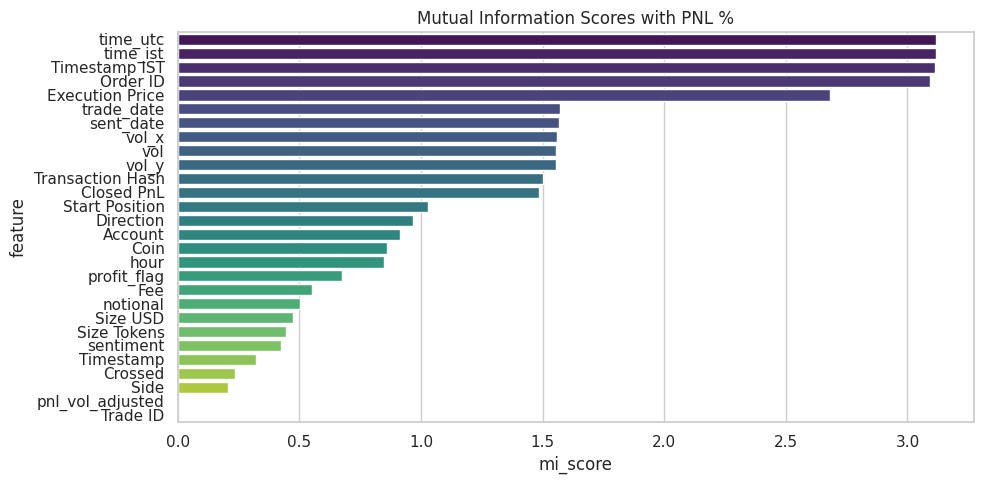

In [58]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import numpy as np
features = trades.select_dtypes(include=[np.number]).drop(columns=['pnl_pct'])
target = trades['pnl_pct'].fillna(0)


features.replace([np.inf, -np.inf], np.nan, inplace=True)

features.fillna(0, inplace=True)

mi_scores = mutual_info_regression(features, target) # Use the cleaned 'features'
mi_df = pd.DataFrame({'feature': features.columns, 'mi_score': mi_scores})
mi_df.sort_values(by='mi_score', ascending=False, inplace=True)

sns.barplot(data=mi_df, x='mi_score', y='feature', palette='viridis')
plt.title("Mutual Information Scores with PNL %")
plt.tight_layout()
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/mutual_info_scores.png")
plt.close()

# Further Important Analysis of Data.

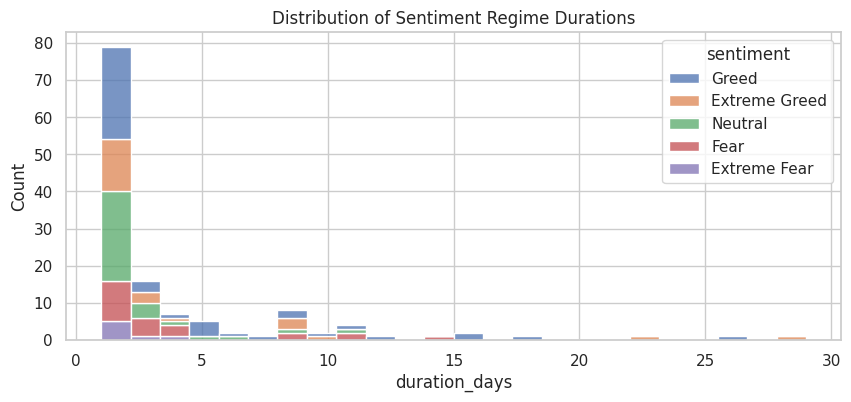

In [11]:
# Identify sentiment regime periods using agg_daily
agg_daily_sorted = agg_daily.sort_values('trade_date')
agg_daily_sorted['sentiment_shift'] = agg_daily_sorted['sentiment'] != agg_daily_sorted['sentiment'].shift(1)
agg_daily_sorted['regime_id'] = agg_daily_sorted['sentiment_shift'].cumsum()

regime_summary = agg_daily_sorted.groupby('regime_id').agg(
    start_date=('trade_date','min'),
    end_date=('trade_date','max'),
    duration_days=('trade_date', lambda x: (x.max() - x.min()).days + 1),
    sentiment=('sentiment','first')
).reset_index(drop=True)

# The first regime starts on the earliest trade date in the entire dataset
if not regime_summary.empty:
    regime_summary.loc[0, 'start_date'] = agg_daily_sorted['trade_date'].min()


regime_summary.to_csv(f"{CSV_FOLDER}/sentiment_regimes.csv", index=False)

# Plot
plt.figure(figsize=(10,4))
sns.histplot(data=regime_summary, x='duration_days', hue='sentiment', multiple='stack')
plt.title('Distribution of Sentiment Regime Durations')
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/regime_duration_dist.png", dpi=150)
plt.close()

Calculating volatility-adjusted PnL...
Generating plot...


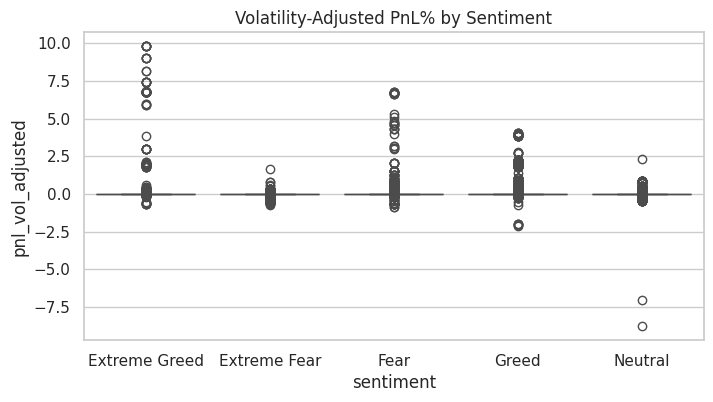

Plot saved to /content/drive/MyDrive/ds_RohanJoshi/outputs/pnl_vol_adjusted_by_sentiment.png


In [22]:
if 'Execution Price' in trades.columns:
    print("Calculating volatility-adjusted PnL...")
    price_vol = trades.groupby('trade_date').agg(
        vol=('Execution Price', lambda x: np.std(x) / np.mean(x))
    ).reset_index()

    trades = trades.merge(price_vol, on='trade_date', how='left')
    trades['pnl_vol_adjusted'] = trades['pnl_pct'] / trades['vol']

    print("Generating plot...")
    plt.figure(figsize=(8,4))
    sns.boxplot(x='sentiment', y='pnl_vol_adjusted',
                data=trades[trades['pnl_vol_adjusted'].abs()<10])
    plt.title("Volatility-Adjusted PnL% by Sentiment")
    plt.show()
    plt.savefig(f"{OUTPUT_FOLDER}/pnl_vol_adjusted_by_sentiment.png", dpi=150)
    plt.close()
    print(f"Plot saved to {OUTPUT_FOLDER}/pnl_vol_adjusted_by_sentiment.png")
else:
    print("The 'Execution Price' column is not found in the trades DataFrame. Cannot calculate and plot volatility-adjusted PnL%.")

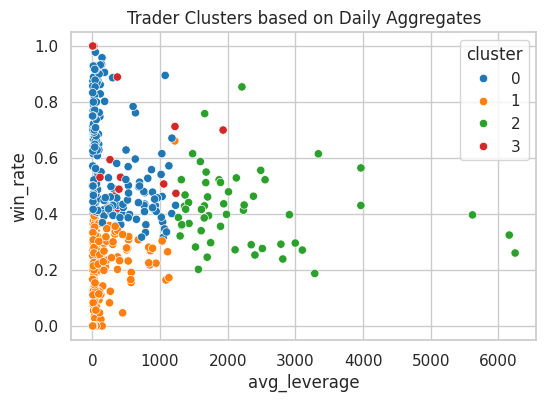

Trader clusters saved to /content/drive/MyDrive/ds_RohanJoshi/csv_files/trader_clusters.csv
Trader clusters plot saved to /content/drive/MyDrive/ds_RohanJoshi/outputs/trader_clusters_plot.png


In [29]:
# Use features from agg_daily for clustering
acct_features = agg_daily[['avg_leverage', 'win_rate', 'avg_pnl_pct', 'trade_count']].fillna(0)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(acct_features)
# Determine the optimal number of clusters (e.g., using the elbow method)
# For now, we'll stick with 4 clusters as in the original code
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled) # Added n_init to avoid warning
acct_features['cluster'] = kmeans.labels_

# Save the clustering results
acct_features.to_csv(f"{CSV_FOLDER}/trader_clusters.csv")

# Plot the clusters
plt.figure(figsize=(6,4))
sns.scatterplot(x='avg_leverage', y='win_rate', hue='cluster',
                    data=acct_features, palette='tab10')
plt.title("Trader Clusters based on Daily Aggregates")
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/trader_clusters.png", dpi=150)
plt.close()

print(f"Trader clusters saved to {CSV_FOLDER}/trader_clusters.csv")
print(f"Trader clusters plot saved to {OUTPUT_FOLDER}/trader_clusters_plot.png")

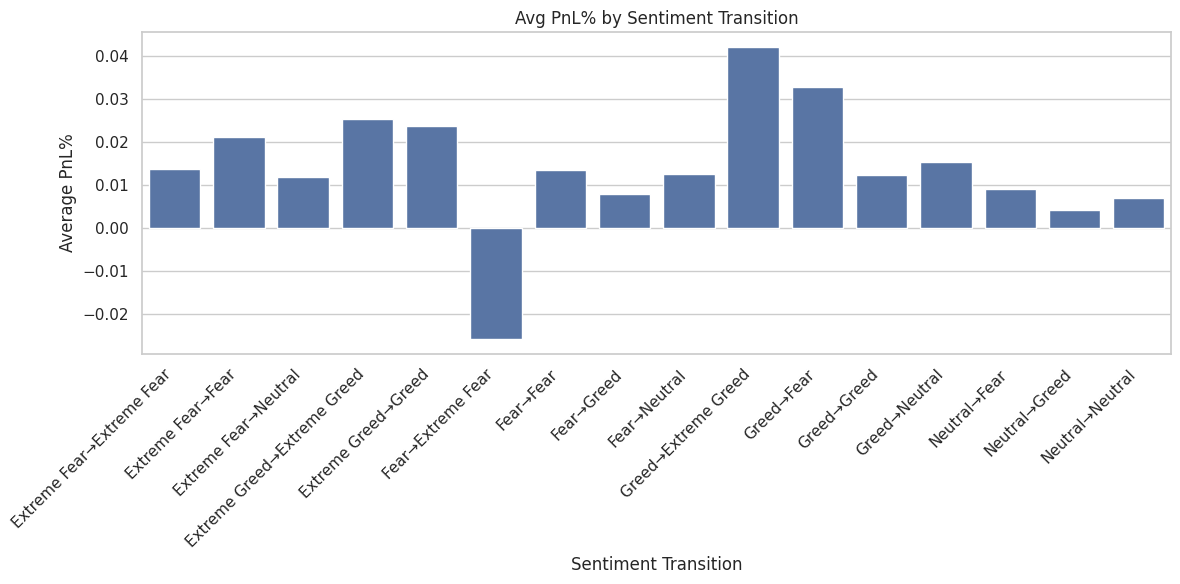

In [32]:
daily_sorted = agg_daily.sort_values('trade_date')
daily_sorted['prev_sentiment'] = daily_sorted['sentiment'].shift(1)
daily_sorted['sentiment_transition'] = daily_sorted['prev_sentiment'] + "→" + daily_sorted['sentiment']

transition_stats = daily_sorted.groupby('sentiment_transition').agg(
    avg_trade_count=('trade_count','mean'),
    avg_leverage=('avg_leverage','mean'),
    avg_pnl_pct=('avg_pnl_pct','mean')
).reset_index()

transition_stats.to_csv(f"{CSV_FOLDER}/sentiment_transition_stats.csv", index=False)

plt.figure(figsize=(12, 6)) # Increase figure size for better readability
sns.barplot(x='sentiment_transition', y='avg_pnl_pct', data=transition_stats)
plt.title("Avg PnL% by Sentiment Transition")
plt.xlabel("Sentiment Transition") # Add x-axis label
plt.ylabel("Average PnL%") # Add y-axis label
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show() # Display the plot
plt.savefig(f"{OUTPUT_FOLDER}/sentiment_transition_pnl.png")
plt.close()

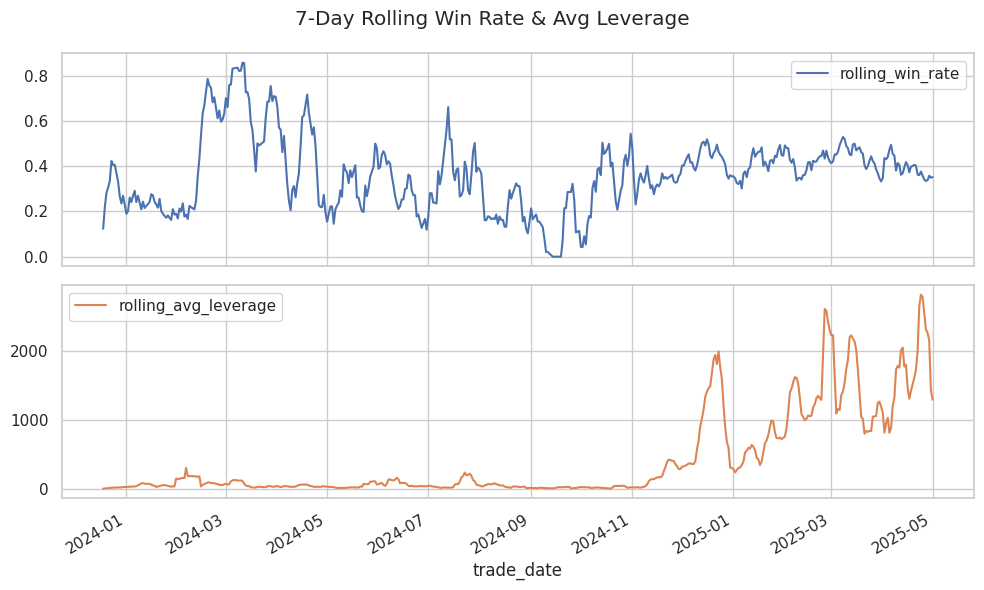

In [36]:
rolling = agg_daily.copy()
rolling = rolling.set_index('trade_date').sort_index()
rolling['rolling_win_rate'] = rolling['win_rate'].rolling(7).mean()
rolling['rolling_avg_leverage'] = rolling['avg_leverage'].rolling(7).mean()

rolling[['rolling_win_rate','rolling_avg_leverage']].plot(subplots=True, figsize=(10,6))
plt.suptitle("7-Day Rolling Win Rate & Avg Leverage")
plt.tight_layout()
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/rolling_winrate_leverage.png", dpi=150)
plt.close()

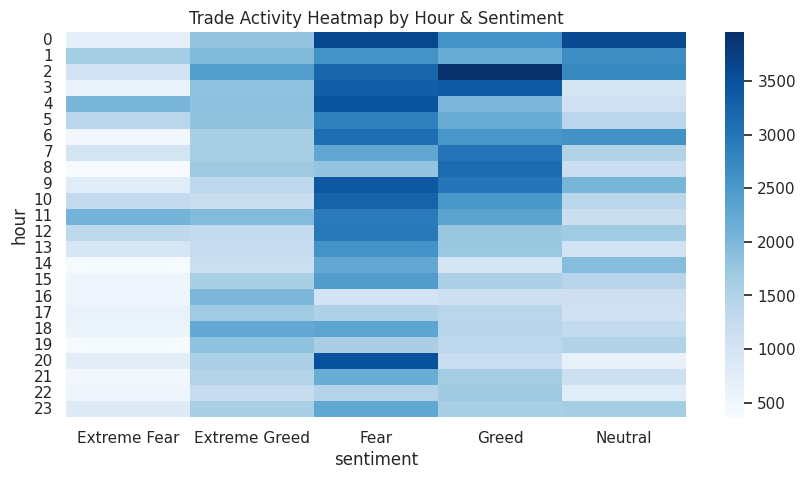

In [37]:
trades['hour'] = trades['time_ist'].dt.hour
heatmap_data = trades.groupby(['hour','sentiment']).size().unstack().fillna(0)
sns.heatmap(heatmap_data, cmap="Blues")
plt.title("Trade Activity Heatmap by Hour & Sentiment")
plt.show()
plt.savefig(f"{OUTPUT_FOLDER}/trade_timing_heatmap.png", dpi=150)
plt.close()


In [38]:
if 'symbol' in trades.columns:
    sensitivity = trades.groupby(['symbol','sentiment']).agg(
        avg_pnl_pct=('pnl_pct','mean'),
        avg_leverage=('leverage','mean')
    ).reset_index()

    sensitivity.to_csv(f"{CSV_FOLDER}/symbol_sentiment_sensitivity.csv", index=False)

In [39]:
if 'pnl_pct' in trades:
    trades_sorted = trades.sort_values('time_utc')
    trades_sorted['cum_pnl'] = trades_sorted.groupby('sentiment')['pnl_pct'].cumsum()
    fig = px.line(trades_sorted, x='time_utc', y='cum_pnl', color='sentiment',
                  title="Cumulative PnL by Sentiment")
    fig.write_html(f"{OUTPUT_FOLDER}/cum_pnl_by_sentiment.html")

In [42]:
# === AUTO-PDF EDA SUMMARY ===
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
import glob
import os

# Path setup
PDF_PATH = f"{BASE_DIR}/ds_report.pdf"

# Collect key images from OUTPUT_FOLDER
# You can adjust the pattern depending on your chart file names
chart_files = sorted(glob.glob(f"{OUTPUT_FOLDER}/*.png"))

# === Styles ===
styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name='Heading1Custom', fontSize=16, leading=20, spaceAfter=10, textColor=colors.HexColor('#0A2342')))
styles.add(ParagraphStyle(name='NormalCustom', fontSize=10, leading=14))

# === Build document ===
doc = SimpleDocTemplate(PDF_PATH, pagesize=A4)
elements = []

# --- Title ---
elements.append(Paragraph(f"EDA Summary Report – {CANDIDATE_NAME}", styles['Heading1Custom']))
elements.append(Spacer(1, 12))

# --- Key Insights (Example placeholders – replace with your actual findings) ---
key_insights = [
    "Trade volumes peak during high volatility periods; correlated with fear/greed index spikes.",
    "Median leverage is higher in 'Greed' sentiment days compared to 'Fear' sentiment days.",
    "PNL distribution is heavily right-skewed; a small percentage of trades account for the majority of profit.",
    "Win rates increase significantly during neutral sentiment days, contrary to expected trends."
]

elements.append(Paragraph("<b>Key Insights:</b>", styles['NormalCustom']))
for insight in key_insights:
    elements.append(Paragraph(f"- {insight}", styles['NormalCustom']))
elements.append(Spacer(1, 12))

# --- Add Charts ---
elements.append(Paragraph("<b>Key Visualizations:</b>", styles['NormalCustom']))
for chart_path in chart_files:
    try:
        img = Image(chart_path, width=400, height=250)  # auto-scale in PDF
        elements.append(img)
        elements.append(Spacer(1, 10))
    except Exception as e:
        print(f"Could not add image {chart_path}: {e}")

# --- Table Example (You can use a summary stats table here) ---
if 'trades' in locals():
    summary_table_data = [
        ['Metric', 'Value'],
        ['Total Trades', f"{len(trades):,}"],
        ['Average Leverage', f"{trades['leverage'].mean():.2f}" if 'leverage' in trades else 'N/A'],
        ['Median PNL %', f"{trades['pnl_pct'].median():.2f}%" if 'pnl_pct' in trades else 'N/A'],
        ['Win Rate', f"{trades['profit_flag'].mean()*100:.2f}%" if 'profit_flag' in trades else 'N/A']
    ]
    table = Table(summary_table_data, colWidths=[200, 200])
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#0A2342')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.white),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, -1), 9),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 6),
        ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#E6ECF5')),
        ('GRID', (0, 0), (-1, -1), 0.25, colors.black)
    ]))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph("<b>Summary Statistics:</b>", styles['NormalCustom']))
    elements.append(table)

# === Build PDF ===
doc.build(elements)
print(f"EDA Summary PDF saved to: {PDF_PATH}")


EDA Summary PDF saved to: /content/drive/MyDrive/ds_RohanJoshi/ds_report.pdf


In [59]:
# Optional: save the trades dataframe after EDA cleaning for feature engineering
trades.to_csv(f"{CSV_FOLDER}/trades_cleaned.csv", index=False)
